**DATASET**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2021-03-16 18:21:10--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2021-03-16 18:21:12 (101 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2021-03-16 18:21:12--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regres

In [4]:
#Load from CSV
train_df = pd.read_csv('regression_dataset/train_data.csv').values
test_df = pd.read_csv('regression_dataset/test_data.csv').values

#Split Full dataset in Train and Validation
X_train=train_df[:,0]
y_train=train_df[:,1]

X_test=test_df[:,0]
y_test=test_df[:,1]

#convert to Pytorch tensor
X_train=np.expand_dims(X_train, axis=1)
y_train=np.expand_dims(y_train, axis=1)
X_train=torch.from_numpy(X_train).float()
y_train=torch.from_numpy(y_train).float()

X_test=np.expand_dims(X_test, axis=1)
y_test=np.expand_dims(y_test, axis=1)
X_test=torch.from_numpy(X_test).float()
y_test=torch.from_numpy(y_test).float()

In [5]:
class Model(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.ReLU()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

In [6]:
pip install -U skorch

     |████████████████████████████████| 133kB 8.8MB/s 


In [7]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Define the loss function
loss_function = nn.MSELoss()

Training device: cpu


In [8]:
from skorch.callbacks import EarlyStopping

boundary = EarlyStopping(
    monitor='valid_loss',
    patience=500,
    threshold=0.001,
    threshold_mode='rel',
    lower_is_better=True)


from skorch import NeuralNetRegressor
# Best parameters {'max_epochs': 1000, 'module__Nh1': 48, 'module__Nh2': 64, 'optimizer__lr': 0.005, 'optimizer__weight_decay': 0.0001}
net = NeuralNetRegressor(
    module=Model,
    module__Ni= 1,
    module__Nh1 = 48,
    module__Nh2 = 128,
    module__No = 1,
    max_epochs=1000,
    device=device,  
    optimizer = optim.AdamW,
    optimizer__lr=0.001,
    optimizer__weight_decay=1e-4,
    criterion=nn.MSELoss,
    callbacks = [boundary],
    verbose=0
)

In [9]:
params = {
    'module__Nh1': [24, 48, 96],
    'module__Nh2': [64, 128, 256],
    'max_epochs':[500, 750, 1000],
    'optimizer__lr':[0.1, 0.01, 0.005],
    'optimizer__weight_decay': [1e-4, 1e-5]  
}

In [10]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(net, params, refit=True, cv=3, scoring="neg_mean_squared_error",verbose=3)

gs.fit(X_train,y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] max_epochs=500, module__Nh1=24, module__Nh2=64, optimizer__lr=0.1, optimizer__weight_decay=0.0001 
Network initialized
Network initialized


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_epochs=500, module__Nh1=24, module__Nh2=64, optimizer__lr=0.1, optimizer__weight_decay=0.0001, score=-285.773, total=   5.1s
[CV] max_epochs=500, module__Nh1=24, module__Nh2=64, optimizer__lr=0.1, optimizer__weight_decay=0.0001 
Network initialized
Network initialized


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV]  max_epochs=500, module__Nh1=24, module__Nh2=64, optimizer__lr=0.1, optimizer__weight_decay=0.0001, score=-0.593, total=   4.8s
[CV] max_epochs=500, module__Nh1=24, module__Nh2=64, optimizer__lr=0.1, optimizer__weight_decay=0.0001 
Network initialized
Network initialized


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s


[CV]  max_epochs=500, module__Nh1=24, module__Nh2=64, optimizer__lr=0.1, optimizer__weight_decay=0.0001, score=-6.243, total=   4.8s
[CV] max_epochs=500, module__Nh1=24, module__Nh2=64, optimizer__lr=0.1, optimizer__weight_decay=1e-05 
Network initialized
Network initialized
[CV]  max_epochs=500, module__Nh1=24, module__Nh2=64, optimizer__lr=0.1, optimizer__weight_decay=1e-05, score=-99.017, total=   4.9s
[CV] max_epochs=500, module__Nh1=24, module__Nh2=64, optimizer__lr=0.1, optimizer__weight_decay=1e-05 
Network initialized
Network initialized
[CV]  max_epochs=500, module__Nh1=24, module__Nh2=64, optimizer__lr=0.1, optimizer__weight_decay=1e-05, score=-2.356, total=   4.9s
[CV] max_epochs=500, module__Nh1=24, module__Nh2=64, optimizer__lr=0.1, optimizer__weight_decay=1e-05 
Network initialized
Network initialized
[CV]  max_epochs=500, module__Nh1=24, module__Nh2=64, optimizer__lr=0.1, optimizer__weight_decay=1e-05, score=-14.085, total=   4.9s
[CV] max_epochs=500, module__Nh1=24, mod

[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed: 65.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.Model'>,
  module__Nh1=48,
  module__Nh2=128,
  module__Ni=1,
  module__No=1,
),
             iid='deprecated', n_jobs=None,
             param_grid={'max_epochs': [500, 750, 1000],
                         'module__Nh1': [24, 48, 96],
                         'module__Nh2': [64, 128, 256],
                         'optimizer__lr': [0.1, 0.01, 0.005],
                         'optimizer__weight_decay': [0.0001, 1e-05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

In [11]:
print(gs.best_score_, gs.best_params_)

-4.762472112973531 {'max_epochs': 1000, 'module__Nh1': 48, 'module__Nh2': 64, 'optimizer__lr': 0.005, 'optimizer__weight_decay': 0.0001}


In [12]:
net=gs.best_estimator_

In [13]:
net.fit(X_train, y_train)

Network initialized


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Model(
    (fc1): Linear(in_features=1, out_features=48, bias=True)
    (fc2): Linear(in_features=48, out_features=64, bias=True)
    (out): Linear(in_features=64, out_features=1, bias=True)
    (act): ReLU()
  ),
)

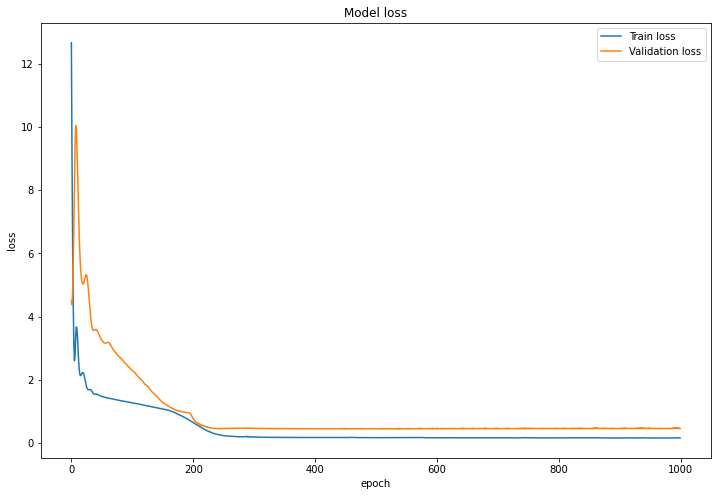

In [14]:
# get train losses from all epochs, a list of floats
history = net.history
train_loss_log=history[:, 'train_loss']
val_loss_log=history[:, 'valid_loss']

# Plot losses
plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.show()


In [19]:
y_pred = net.predict(X_train)
y_pred = torch.from_numpy(y_pred).float()

train_loss = loss_function(y_pred, y_train)
print(f"TRAIN LOSS: {train_loss}")

y_pred = net.predict(X_test)
y_pred = torch.from_numpy(y_pred).float()

test_loss = loss_function(y_pred, y_test)
print(f"TEST LOSS: {test_loss}")

TRAIN LOSS: 0.21512888371944427
TEST LOSS: 0.0823521539568901


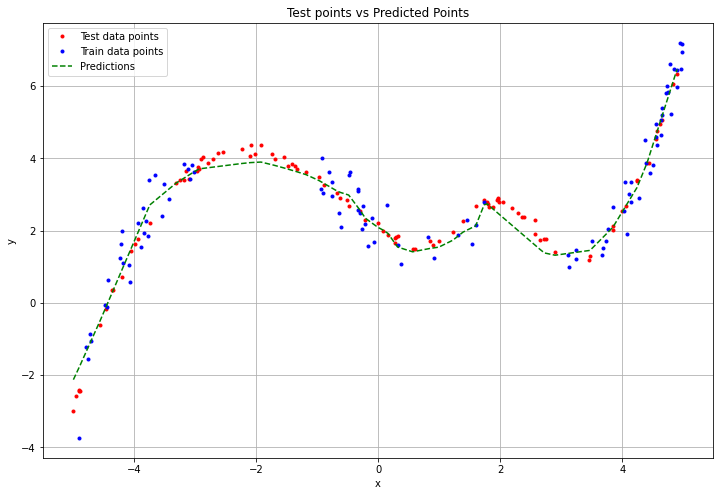

In [21]:
#Plot Test points vs Prdicted points
zipped_lists = zip(X_test, y_pred)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
X, y = [ list(tuple) for tuple in  tuples]

plt.figure(figsize=(12,8))
plt.plot(X_test, y_test, color='r', ls='', marker='.')
plt.plot(X_train, y_train, color='b', ls='', marker='.')
plt.plot(X, y, color='g', ls='--')
plt.title('Test points vs Predicted Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(['Test data points', 'Train data points', 'Predictions'], loc='upper left')
plt.show()

In [17]:
train_loss=train_loss_log[-1]

#Val loss
val_loss=val_loss_log[-1]

print("Train Loss:\t",round(train_loss,3))
print("Val Loss:\t",round(val_loss,3))
print("Test Loss:\t",round(float(test_loss),3))

Train Loss:	 0.157
Val Loss:	 0.455
Test Loss:	 0.082


In [22]:
#Access network parameters
my_best_net = net.module_

#First hidden Layer
h1_w = my_best_net.fc1.weight.data.cpu().numpy()
h1_b = my_best_net.fc1.bias.data.cpu().numpy()

#Second hidden Layer
h2_w = my_best_net.fc2.weight.data.cpu().numpy()
h2_b = my_best_net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = my_best_net.out.weight.data.cpu().numpy()
out_b = my_best_net.out.bias.data.cpu().numpy()

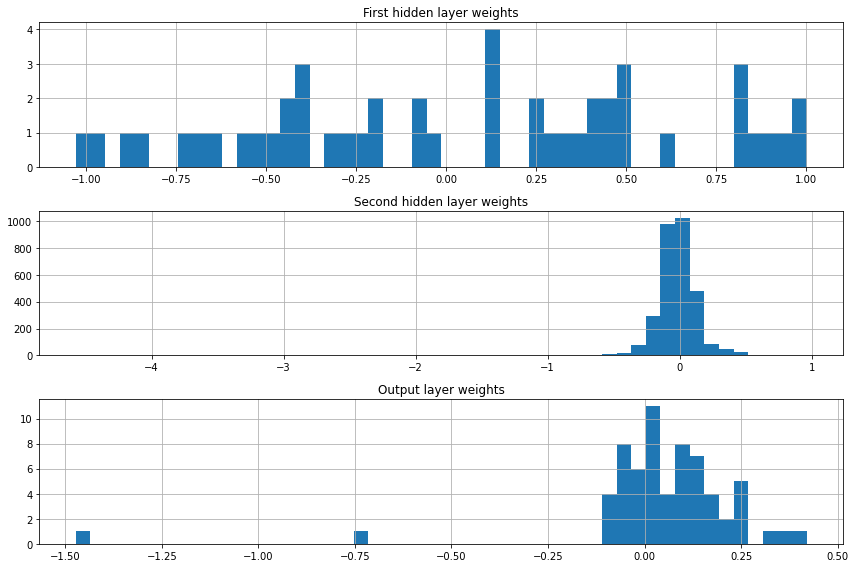

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

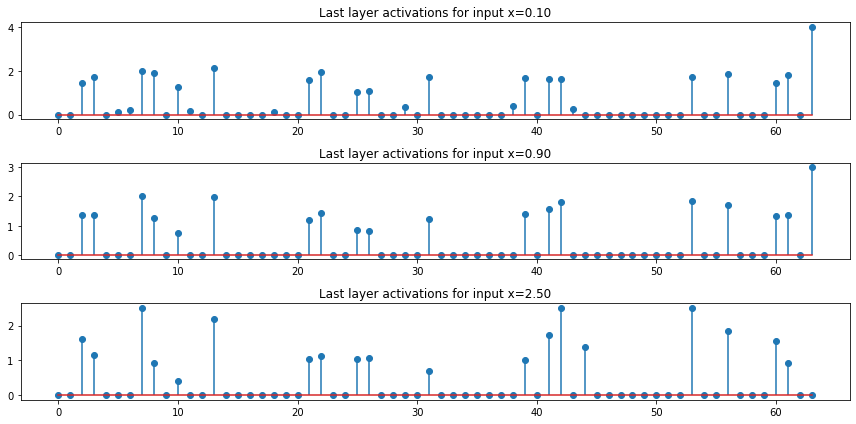

In [26]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)
    
### Register hook
hook_handle = my_best_net.fc2.register_forward_hook(get_activation)

### Analyze activations
my_best_net = my_best_net.to(device)
my_best_net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = my_best_net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = my_best_net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = my_best_net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()